In [1]:
import tiktoken
import re

In [2]:
with open("the-verdict.txt", "r") as f:
    lines = f.read()

print(len(lines))

20479


In [3]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', lines)
print(preprocessed[:10])
preprocessed = [item for item in preprocessed if item.strip()]
print(len(preprocessed))

['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ']
4690


In [4]:
all_words = sorted(set(preprocessed))
print(all_words[-10:])
vocab_size = len(all_words)
print(vocab_size)
vocab = {token: idx for idx, token in enumerate(all_words)}
for i, word in enumerate(vocab):
    if i > 10:
        break
    print(word, vocab[word])

['would', 'wouldn', 'year', 'years', 'yellow', 'yet', 'you', 'younger', 'your', 'yourself']
1130
! 0
" 1
' 2
( 3
) 4
, 5
-- 6
. 7
: 8
; 9
? 10


In [5]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.token_to_int = vocab
        self.int_to_token = {idx: token for token, idx in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item for item in preprocessed if item.strip()]
        return [self.token_to_int[token] for token in preprocessed]
    
    def decode(self, integers):
        text = " ".join([self.int_to_token[idx] for idx in integers])
        # replaces spaces before punctuation marks for format sentences correctly
        text = re.sub(r'\s+([,.:;?_!"()\'])', r'\1', text)
        return text
    
tokenizer = SimpleTokenizerV1(vocab)
test = "their  was.."
print(tokenizer.encode(test))
print(tokenizer.decode(tokenizer.encode(test)))



[989, 1077, 7, 7]
their was..


In [6]:
all_words.extend(["<|unk|>", "<|endoftext|>"])
all_words
vocab = {token: idx for idx, token in enumerate(all_words)}
max = 10
for i, item in enumerate(list(vocab.items())[-5:]):
    if i > max:
        break
    print(item)
text1 = "Hi, do you like tea?"
text2 = "In the sunlit terraces"
text = " <|endoftext|> ".join((text1, text2))

print(text)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|unk|>', 1130)
('<|endoftext|>', 1131)
Hi, do you like tea? <|endoftext|> In the sunlit terraces


In [7]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.token_to_int = vocab
        self.int_to_token = {idx: token for  token, idx in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.token_to_int else "<|unk|>" for item in preprocessed]
        return [self.token_to_int[token] for token in preprocessed]

    def decode(self, integers):
        text = " ".join([self.int_to_token[idx] for idx in integers])
        # replaces spaces before punctuation marks for format sentences correctly
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV2(vocab)
encoded = tokenizer.encode(text)
# tokenizer.int_to_token.keys()
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)
print(tokenizer.decode(tokenizer.encode(text)))


[1130, 5, 355, 1126, 628, 975, 10, 1131, 55, 988, 956, 984]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces


In [8]:
bpe_tokenizer = tiktoken.get_encoding("gpt2")
text = (
"Hello, do you like tea? <|endoftext|> In the sunlit terraces"
"of someunknownPlace."
)
encoded = bpe_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(encoded)
strings = bpe_tokenizer.decode(encoded)
print(strings)


[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [9]:
new_word = "Akwirw ier"

encoded = bpe_tokenizer.encode(new_word)
print(encoded)
decoded = bpe_tokenizer.decode(encoded)
print(decoded)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [10]:
with open("the-verdict.txt", "r") as f:
    lines = f.read()

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', lines)
print(preprocessed[:10])
preprocessed = [item for item in preprocessed if item.strip()]
print(len(lines))
all_words = sorted(set(preprocessed))
all_words.extend(["<|unk|>", "<|endoftext|>"])
print(all_words[-10:])
vocab_size = len(all_words)
enc_text = bpe_tokenizer.encode(lines)
vocab_size = len(enc_text)
print(enc_text[:10])



['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ']
20479
['year', 'years', 'yellow', 'yet', 'you', 'younger', 'your', 'yourself', '<|unk|>', '<|endoftext|>']
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138]


In [11]:
block_size = 2
enc_sample = enc_text[50:]
for i in range(block_size):
    x = enc_sample[i:block_size]
    y = enc_sample[i+1:i+block_size+1]
    print(x)
    print(y)
    print(bpe_tokenizer.decode(x), "-->", bpe_tokenizer.decode(y))
    break


[290, 4920]
[4920, 2241]
 and established -->  established himself


In [12]:
import torch
from torch.utils.data import DataLoader, Dataset

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        self.encoded = tokenizer.encode(text)
        #max_length = block_size or context_length, so need to substract max_length from range as that will be size of the sliced array 
        for i in range(0, len(self.encoded) - max_length, stride):
            input_chunk = self.encoded[i:i+max_length]
            targets = self.encoded[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(targets))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])


dataset = GPTDatasetV1(lines, tokenizer, 4, 1)
dataset[1]




(tensor([  44,  149, 1003,   57]), tensor([ 149, 1003,   57,   38]))

In [13]:

def create_dataloader_v1(text, batch_size, max_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text, tokenizer=tokenizer, max_length=max_length, stride=stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, drop_last=drop_last, shuffle=shuffle)
    return dataloader

dataloader = create_dataloader_v1(lines, batch_size=4, max_length=4, stride=1, shuffle=False)

first_batch = next(iter(dataloader))

first_batch[0].shape

torch.Size([4, 4])

In [14]:

dataloader = create_dataloader_v1(lines, batch_size=4, max_length=4, stride=3, shuffle=False)

first_batch = next(iter(dataloader))

first_batch

[tensor([[   40,   367,  2885,  1464],
         [ 1464,  1807,  3619,   402],
         [  402,   271, 10899,  2138],
         [ 2138,   257,  7026, 15632]]),
 tensor([[  367,  2885,  1464,  1807],
         [ 1807,  3619,   402,   271],
         [  271, 10899,  2138,   257],
         [  257,  7026, 15632,   438]])]

### Chapter 3
Prior to transformers, RNNs were a popular architecture for NLP tasks such as machine translation. These networks consist of an encoder and decoder network. The encoder processes a sequence of tokens, where the first token is passed to the first hidden layer, the second is passed to the second layer state AS WELL AS the hidden state of the first token. The last hidden state of the encoder is passed to the decoder network, therefore it relies solely on the encapsulated context from the last hidden state of the encoder. It does not have direct access to previous tokens/hidden states (e.g words in a sentence), but only the last generated hidden state from the encoder. Although the the task of the encoder is to generate a sufficiently rich representation of the entire embedded sentence, this is remains limited to short sequence lengths and highlights the main limitation of the classical RNN architecture.

#### Bahdanau attention (2014)

Modified the encoder-decoder RNN so the decoder can selectively access different parts of the input sequence at each decoding step. 

#### Scaled dot product attention

The following implements self-attention where the dot products are scaled by the dimension of the compute key matrix encoding representations of the tokens after apply the key weights matrix. The reason for normalised and scaling these values is to improve training performance. For large architectures that use a large embedding dimension (e.g 1000 for GPT models), large dot products can result in very small gradients during backpropagation due to the softmax function. If one value dominates output from the dot product, the softmax normalisation will accordingly scale all the remaining values to very small values. Scaling by the sqrt of the embedding dim prevents these very large values from dominating the normalisation.


In [15]:

tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab
output_dim = 3  # for illustration
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
input_ids, target_ids = first_batch
inputs = token_embedding_layer(input_ids)

print(inputs[1])
print("input shape", inputs.shape)

x2 = inputs[1][1]
d_in = x2.shape[0]
d_out = 2

torch.manual_seed(0)
W_query = torch.nn.Parameter(torch.randn(d_in, d_out))
K_query = torch.nn.Parameter(torch.randn(d_in, d_out))
V_query = torch.nn.Parameter(torch.randn(d_in, d_out))


x2_query = x2 @ W_query # query vector for 2nd token in the first example of the batch
keys = inputs[1] @ K_query # key matrix for all tokens in the first example of the batch
values = inputs[1] @ V_query # value matrix for all tokens in the first example of the batch

print(x2_query.shape) # query vector
print(keys.shape) # 

# attention score
tmp_score = 0
x2_key = keys[1]
for i in range(2):
    tmp_score += x2_query[i] * x2_key[i]
    print(tmp_score)
attention_score_22 = x2_query.dot(keys[1])
print(attention_score_22)

attention_scores_2 = x2_query @ keys.T
# softmax normalisation
d_k = keys.shape[1] # embedding dimension of the keys
# SCALED DOT PRODUCT ATTENTION
attention_weights_2 = torch.nn.functional.softmax(attention_scores_2 / (d_k ** 0.5), dim=-1)
attention_weights_2

# context vector calculation
print(f"attention_scores_2 shape: {attention_scores_2.shape}")
print(f"values shape: {values.shape}")
context_vector_2 = attention_weights_2 @ values
context_vector_2 # represents relative importance of all the input tokens wrto the 2nd token in the first example of the batch

context_vector_2


tensor([[ 0.0280, -1.5794, -1.2866],
        [ 2.2193,  0.5818,  0.6965],
        [ 0.0583,  0.7548, -1.3453],
        [ 0.6103,  0.5915,  0.2866]], grad_fn=<SelectBackward0>)
input shape torch.Size([4, 4, 3])
torch.Size([2])
torch.Size([4, 2])
tensor(0.0853, grad_fn=<AddBackward0>)
tensor(-2.1828, grad_fn=<AddBackward0>)
tensor(-2.1828, grad_fn=<DotBackward0>)
attention_scores_2 shape: torch.Size([4])
values shape: torch.Size([4, 2])


tensor([ 1.2619, -0.3508], grad_fn=<SqueezeBackward4>)

In [16]:
class SelfAttention_v1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.Q = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.K = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.V = torch.nn.Parameter(torch.randn(d_in, d_out))
    
    def forward(self, x):
        query = x @ self.Q
        keys = x @ self.K
        values = x @ self.V
        attention_scores = query @ keys.T
        d_k = keys.shape[1]
        # rescale the attention scores because dot products can be large when embedding dimension is large
        # i.e the sum is taken over the embedding dimension, so many values result in a large dot product
        # results in very small gradients
        attention_weights = torch.nn.functional.softmax(attention_scores / (d_k ** 0.5), dim=-1)
        context_vector = attention_weights @ values
        return context_vector

class SelfAttention_v2(torch.nn.Module):
    def __init__(self, d_in, d_out, qkv_bias: bool = False):
        super().__init__()
        # proper initialization of weights in torch nn.Linear modules
        self.Q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.K = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.V = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    
    def forward(self, x):
        query = self.Q(x)
        keys = self.K(x)
        values = self.V(x)
        attention_scores = query @ keys.T
        d_k = keys.shape[1]
        attention_weights = torch.nn.functional.softmax(attention_scores / (d_k ** 0.5), dim=-1)
        context_vector = attention_weights @ values
        return context_vector

    




In [17]:
inputs.shape

torch.Size([4, 4, 3])

In [18]:
# compare SelfAttentionV1 and V2
d_in = inputs.shape[-1] # embedding dim
d_out = 2
print(f"d_in {d_in}, d_out {d_out}")
sa_v1 = SelfAttention_v1(d_in=d_in, d_out=d_out)
sa_v2 = SelfAttention_v2(d_in=d_in, d_out=d_out)

x2 = inputs[1]
print(x2.shape)
sa_v1_mat = sa_v1(inputs[1])
sa_v2_mat = sa_v2(inputs[1])
print("sa_v1")
print(sa_v1_mat[0])
print("sa_v2")
print(sa_v2_mat[0])

print(sa_v1.Q.shape)
print(sa_v2.Q.weight.shape)

sa_v1.Q = torch.nn.Parameter(sa_v2.Q.weight.T)
sa_v1.V = torch.nn.Parameter(sa_v2.V.weight.T)
sa_v1.K = torch.nn.Parameter(sa_v2.K.weight.T)
print("updated sa_v1")
sa_v1_mat_up = sa_v1(inputs[1])
print(sa_v1_mat_up[0])



d_in 3, d_out 2
torch.Size([4, 3])
sa_v1
tensor([ 1.0938, -0.2683], grad_fn=<SelectBackward0>)
sa_v2
tensor([ 0.0730, -0.2277], grad_fn=<SelectBackward0>)
torch.Size([3, 2])
torch.Size([2, 3])
updated sa_v1
tensor([ 0.0730, -0.2277], grad_fn=<SelectBackward0>)


In [19]:
# masked self-attention (causal self-attention)
# ensures that no current position is influenced by future positions (e.g for generative tasks)
queries = sa_v2.Q(inputs)
keys = sa_v2.K(inputs)
print(queries.shape, keys.shape)
attention_scores = queries @ keys.transpose(1,2)
# normalisation of scores to they form a probability distribution summing to 1 - this is applied along the embedding dim 
attention_weights = torch.nn.functional.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)

context_length = inputs.shape[1]
print(f"context length {context_length}")
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)
print(mask.bool())
# negative infinity approaches 0 in softmax function (because e-inf approaches 0)
attention_scores_masked = attention_scores.masked_fill_(mask.bool(), -torch.inf)
print(attention_scores_masked)
# normalised weights
attention_weights = torch.nn.functional.softmax((attention_scores_masked) / keys.shape[-1] ** 0.5, dim=-1)
attention_weights

torch.Size([4, 4, 2]) torch.Size([4, 4, 2])
context length 4
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])
tensor([[[-0.8525,    -inf,    -inf,    -inf],
         [ 0.3941, -0.0829,    -inf,    -inf],
         [-1.2522,  0.3203, -0.1983,    -inf],
         [ 1.6815, -0.5202,  0.9057, -1.7346]],

        [[-1.7346,    -inf,    -inf,    -inf],
         [ 1.4834,  0.3129,    -inf,    -inf],
         [-0.3322,  0.9269,  0.7625,    -inf],
         [ 0.7294, -0.0308,  0.5238, -0.0939]],

        [[-0.0939,    -inf,    -inf,    -inf],
         [-0.1420,  0.6980,    -inf,    -inf],
         [ 0.0889, -0.2988,  0.0962,    -inf],
         [ 0.1063,  0.2906, -0.1457, -0.1490]],

        [[-0.1490,    -inf,    -inf,    -inf],
         [ 0.1830,  0.0379,    -inf,    -inf],
         [ 0.2817

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5835, 0.4165, 0.0000, 0.0000],
         [0.1627, 0.4946, 0.3428, 0.0000],
         [0.5325, 0.1123, 0.3077, 0.0476]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6959, 0.3041, 0.0000, 0.0000],
         [0.1784, 0.4346, 0.3869, 0.0000],
         [0.3325, 0.1942, 0.2875, 0.1858]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3557, 0.6443, 0.0000, 0.0000],
         [0.3616, 0.2749, 0.3635, 0.0000],
         [0.2624, 0.2989, 0.2196, 0.2191]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5256, 0.4744, 0.0000, 0.0000],
         [0.4625, 0.2772, 0.2604, 0.0000],
         [0.3258, 0.1724, 0.2210, 0.2808]]], grad_fn=<SoftmaxBackward0>)

In [20]:
# Dropout
# only applied during training, not inference
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones((context_length, context_length))
# to compensate for the reduction in active units, the un-zero'd values are scaled by (original_val / dropout_prob (0.5))
# 1 / 0.5 = 2
# this ensures the overall influence of the weight is consistent at both training and inference time
print(dropout(example))

tensor([[2., 2., 0., 2.],
        [2., 0., 0., 0.],
        [0., 2., 0., 2.],
        [2., 2., 2., 2.]])


In [21]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias: bool= False):
        super().__init__()
        self.d_out = d_out
        self.dropout = torch.nn.Dropout(dropout)
        self.Q = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.K = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.V = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        batch, num_token, d_in = x.shape
        keys = self.K(x)
        queries = self.Q(x)
        values = self.V(x)
        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool()[:num_token, :num_token], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec
        


In [22]:
context_length = inputs.shape[1]
ca=CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(inputs)
context_vecs.shape



torch.Size([4, 4, 2])

In [23]:
# multihead attention
# apply multiple query key and value matrices (one for each head) in parallel

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), f"d_out {d_out} must be divisible by num heads {num_heads}"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.Q = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.K = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.V = torch.nn.Linear(in_features=d_in, out_features=d_out)
        self.out_proj = torch.nn.Linear(in_features=d_out, out_features=d_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        batch, num_token, d_in = x.shape
        keys = self.K(x)
        queries = self.Q(x)
        values = self.V(x)
        keys = keys.view(batch, num_token, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_token, self.num_heads, self.head_dim)
        values = values.view(batch, num_token, self.num_heads, self.head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_token, :num_token]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        # contiguous makes a copy of the tensor with the final memory layout specified by the tensor shape
        context_vec = context_vec.contiguous().view(batch, num_token, self.d_out)
        # project layer
        context_vec = self.out_proj(context_vec)
        return context_vec
        


In [24]:
torch.manual_seed(123)

batch_size, context_length, d_in = inputs.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.5, num_heads=2)
out = mha(inputs)
out.shape

torch.Size([4, 4, 2])

In [25]:
# gpt-2 sized MHA

embedding_dim = 768
num_heads = 12
context_length = 1024

dataloader = create_dataloader_v1(lines, batch_size=2, max_length=context_length, stride=1, shuffle=False)
first_batch = next(iter(dataloader))
print(first_batch[0].shape)

vocab_size = tokenizer.n_vocab
token_embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)
input_ids, target_ids = first_batch
inputs = token_embedding_layer(input_ids)

inputs[0].shape

mha = MultiHeadAttention(d_in=768, d_out=768, context_length=context_length, dropout=0.2, num_heads=12)

out = mha(inputs)

out.shape

torch.Size([2, 1024])


torch.Size([2, 1024, 768])

In [63]:
# GPT-2 implementation
# vocab size is determined by the BPE tokenizer
GPT_CONFIG_124M = {"vocab_size": 50257, "context_length": 1024, "emb_dim": 768, "n_heads": 12, "n_layers": 12, "drop_rate": 0.1, "qkv_bias": False}

class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # Parameter = trainable parameter in torch
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # dim = -1  --> embedding dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

first_batch
embedding_dim = 768 
ln = LayerNorm(embedding_dim)
out_ln = ln(inputs)
# expect mean = 0 and var = 1
out_ln.mean(dim=-1), out_ln.var(dim=-1, unbiased=False)


(tensor([[-1.3039e-08, -9.3132e-09, -6.2088e-10,  ..., -3.1044e-09,
          -7.4506e-09, -4.9671e-09],
         [-9.3132e-09, -6.2088e-10, -1.4901e-08,  ..., -7.4506e-09,
          -4.9671e-09,  2.4835e-09]], grad_fn=<MeanBackward1>),
 tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        grad_fn=<VarBackward0>))

In [64]:
# GELU activation function

class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        value = 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
        return value



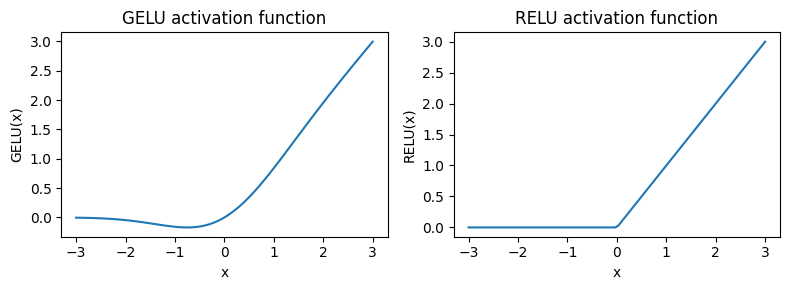

In [65]:
# GELU compared to RELU
import matplotlib.pyplot as plt

gelu, relu = GELU(), torch.nn.ReLU()

x = torch.linspace(-3, 3, 100)

gelu_out = gelu(x)
relu_out = relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([gelu_out, relu_out], ["GELU","RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
plt.tight_layout()
plt.show()

# GELU is a smooth, non-linear function that is differentiable at almost any negative value (except ~ -0.75). 
# Better optimisation due to:
# 1. smoothness
# 2. differential for negative values so these can contribute to the gradients/optimisation process

In [68]:
# Feedforward with GELU
# Feedforward layers enable richer representations through expansion to higher dimensions 

class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), GELU(), torch.nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']))
    
    def forward(self, x):
        out = self.layers(x)
        return out

print(GPT_CONFIG_124M)

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn((2, 3, 768))
out = ffn(x)




{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [ ]:
# Skip connections
# Create an alternative path for the gradient flow by adding the output from layer to the output of a later layer 
# First applied in "residual" networks in computer vision
# Help with optimisation process as the addition of the input (e.g x) to the output from a layer increase the magnitude of the values
# Thus helps with the vanishing gradient problem

class DeepNeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, use_skip):
        super().__init__()
        self.use_skip = use_skip
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()), torch.nn.Sequential(torch.nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())])
    
    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            if self.use_skip and x.shape == out.shape:
                x = out + x
            else:
                x = out
        return x
                
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0., -1]])
torch.manual_seed(123)
model_no_skip = DeepNeuralNetwork(layer_sizes, False)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = torch.nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


print("no skip")
print_gradients(model_no_skip, sample_input)

print("skip")
model_skip = DeepNeuralNetwork(layer_sizes, True)
print_gradients(model_skip, sample_input)


no skip
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031
skip
layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846951924264431
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


In [83]:
# Transformer implementation - combines all of the above

class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        shortcut = x
        # layer norm
        x = self.norm1(x)
        # multihead attn
        x = self.att(x)
        # dropout
        x = self.drop_shortcut(x)
        # skip connection
        x = x + shortcut
        shortcut = x
        # layer norm
        x = self.norm2(x)
        # feedforward
        x = self.ff(x)
        # dropout
        x = self.drop_shortcut(x)
        # skip connection
        x = x + shortcut
        return x


torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

# The preservation of shape throughout the transformer block
# architecture is not incidental but a crucial aspect of its
# design. This design enables its effective application across a
# wide range of sequence-to-sequence tasks, where each
# output vector directly corresponds to an input vector,
# maintaining a one-to-one relationship

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [88]:
# GPT Model
from torch import nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        #1
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
print(first_batch[0].shape)
out = model(first_batch[0])
print("Input batch:\n", first_batch[0])
print("\nOutput shape:", out.shape)
print(out)


torch.Size([2, 1024])
Input batch:
 tensor([[   40,   367,  2885,  ...,   691, 12226,   318],
        [  367,  2885,  1464,  ..., 12226,   318,   284]])

Output shape: torch.Size([2, 1024, 50257])
tensor([[[ 0.1187, -0.1796, -0.6110,  ...,  0.0130, -1.3194,  0.1855],
         [ 0.3433, -0.4382,  0.3009,  ..., -0.6556, -1.0232, -0.4446],
         [ 0.0872,  0.0704, -1.1122,  ..., -0.0253, -0.9942, -0.1097],
         ...,
         [ 0.0912,  1.0045,  0.0662,  ...,  0.1016, -0.2378,  0.0536],
         [ 0.0238,  0.8239, -0.7458,  ...,  0.1565, -0.5105, -0.4867],
         [-0.2985, -0.6460, -0.3411,  ..., -0.4631, -0.3258, -0.0331]],

        [[-0.0576, -0.7426, -0.7723,  ...,  0.1837, -0.7695, -0.3656],
         [ 0.6787, -0.1122,  0.3471,  ..., -0.5583, -1.1185, -0.3215],
         [ 0.9600, -0.2068, -1.1007,  ...,  0.2360, -0.9795, -0.9828],
         ...,
         [-0.4394,  0.0363, -0.4366,  ..., -0.2182, -1.5601, -0.4550],
         [ 0.2571,  1.3750, -0.5499,  ..., -0.2535,  0.1757, -0

In [92]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Total number of parameters: 163,037,184
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,439,808


In [ ]:
# exercise
# Calculate and compare the number of parameters that are
# contained in the feed forward module and those that are
# contained in the multi-head attention module.